# Test Clustering from Edges

We have limited performance when counting the number of correct edges against the number of faulty edges. However, this does not indicate that we have poor performance when evaluating out clusters. Even though we have some proportion of faulty edges, due to our high number of correct edges we might have a strong ability to cluster sequences. Let's try.

In this case we'll need adjacency matrices. Let's test the performance in a single region first.

## Imports

In [93]:
import numpy as np
import matplotlib.pyplot as plt
import os
import time
from itertools import repeat
import multiprocessing
from joblib import Parallel, delayed
import matplotlib
import pandas as pd

import networkx as nx


## Function Calls

In [45]:
"""
Returns sorted seqs and labels by labels from fastq file
"""
def readFastq(adjacency_file):
    fastqFile = os.path.join("../../../output/HG002_20bp/all_chr", adjacency_file).replace("npy", "fastq")
    seqs :list[str] = []
    labels :list[str] = []
    with open(fastqFile,"r") as f:
        i = 0
        curHap = -1
        for line in f.readlines():
            if i % 4 == 0:
                for segment in line.strip().split(" "):
                    if segment.startswith("HP"):
                        curHap = segment.split(":")[-1]
            elif i % 4 == 1:
                if curHap == -1:
                    continue
                curSeq = line.strip()
                seqs.append(curSeq)
                labels.append(curHap)
                curHap = -1
                curSeq = ""
            i += 1
    seqs, labels = zip(*sorted(zip(seqs, labels), key = lambda x : x[1]))
    return seqs, labels

"""
Generate true positive rate and false positive rate for a given adjacency matrix
"""
def tpr_fpr(labels, adjacencyMatrix):
    firstOcc = labels.index("2")
    n = len(labels)

    trueMask = np.zeros((n , n), dtype = bool)
    trueMask[:firstOcc, :firstOcc] = 1
    trueMask[firstOcc:, firstOcc:] = 1

    true_pos = int(np.sum(adjacencyMatrix, where = trueMask)/2)
    tot_pos = int((np.sum(trueMask) - n)/2)
    false_pos = int(np.sum(adjacencyMatrix, where = ~trueMask)/2)
    tot_neg = int(np.sum(~trueMask)/2)

    local_counts = np.array([true_pos, tot_pos, false_pos, tot_neg])

    return local_counts

## Visualize adjacency graphs

[190 231  32 234]


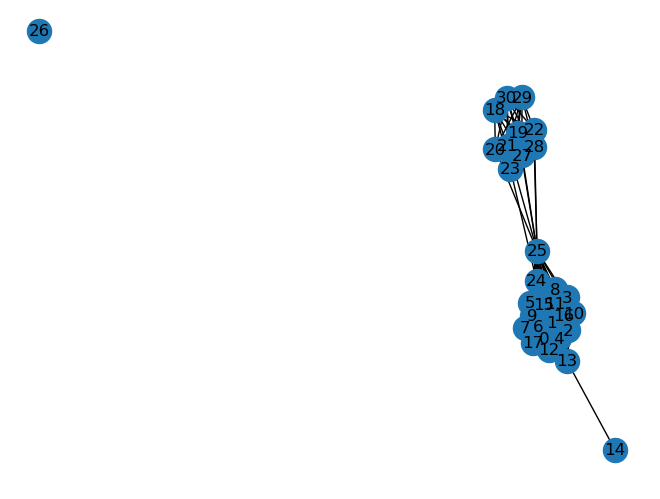

chr6_30678027-30678141.npy ('1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2')


In [98]:
adjacency_dir = "../../../output/adjacency_matrices/1000,7,1,1_band_size=110"
adjacency_files = os.listdir(adjacency_dir)

rand_indices = np.random.randint(0, len(adjacency_files), size=1)

adjacency_matrices = []
labels = []
files = []

for index in rand_indices:
    local_file = adjacency_files[index]
    local_path = os.path.join(adjacency_dir, local_file)
    local_am = np.load(local_path)
    adjacency_matrices.append(local_am)
    _, local_labels = readFastq(local_file)
    labels.append(local_labels)
    files.append(local_file)
    print(tpr_fpr(local_labels, local_am))

for i, am in enumerate(adjacency_matrices):
    G = nx.Graph(am)
    nx.draw(G, with_labels = True)
    plt.show()
    print(files[i], labels[i])

In [100]:
for i,j in enumerate(labels[0]):
    print(i,j)

0 1
1 1
2 1
3 1
4 1
5 1
6 1
7 1
8 1
9 1
10 1
11 1
12 1
13 1
14 1
15 1
16 1
17 1
18 2
19 2
20 2
21 2
22 2
23 2
24 2
25 2
26 2
27 2
28 2
29 2
30 2


Based on this visualization. I think we should label every connected component as one label, and leave out the disconnected components. Then plot our new TPR, FPR graphs based on these calculations. This should improve our accuracy by a lot!

## Calculate new true/false positive rates using nodes instead of edges

In [66]:
"""
Take in an adjacency matrix and a labels. Produce a count numpy vector containing 
    # Counts: [
    #   Number of Components, 
    #   Accuracy( -> with singletons), 
    #   Number of Nodes in Correctly Labeled Group (not singletons), 
    #   Total Number of Nodes
    # ]
"""
def get_counts(labels, adjacency_matrix):
    G = nx.Graph(adjacency_matrix)

    counts = np.zeros((4))
    counts[3] = len(labels)
    for component in nx.connected_components(G):
        counts[0] += 1
        component_label_counts = np.zeros((2))
        for node in component:
            ind = int(labels[node])-1
            component_label_counts[ind] += 1
        component_label = np.argmax(component_label_counts) + 1
        for node in component:
            if int(labels[node]) == component_label:
                counts[1] += 1
            if int(labels[node]) == component_label and len(component) > 1:
                counts[2] += 1
    return counts

"""
Wrapper function to be called in parallel, returns output list and 
"""
def generate_counts_for_region(adjacency_dir, adjacency_file):
    adjacency_matrix = np.load(os.path.join(adjacency_dir, adjacency_file))
    _, labels = readFastq(adjacency_file)
    counts = get_counts(labels, adjacency_matrix)

    return counts

"""
Generate sum of counts across every region in parallel
"""
def parallelize_counts(adjacency_dir):
    files = os.listdir(adjacency_dir)
    inputs = zip(repeat(adjacency_dir), files)

    num_cores = multiprocessing.cpu_count()

    print("Running Parallel Step")
    start = time.time()
    outputs = Parallel(n_jobs=num_cores, verbose=0)(delayed(generate_counts_for_region)(i, j) for i, j  in inputs)
    print("Total time\t:", time.time() - start)

    output = np.zeros((4, len(outputs)))
    for i, a in enumerate(outputs):
        output[:,i] = np.array(a)

    return output, files

# Counts: [
    #   Number of Components, 
    #   Accurate ( -> with singletons) count, 
    #   Number of Nodes in Correctly Labeled Group (not singletons), 
    #   Total Number of Nodes
    # ]
def counts_to_results(counts):
    summed_counts = counts.sum(axis = 1)

    percent_decrease_alignment = 1 - summed_counts[0]/summed_counts[3]
    accuracy = summed_counts[1] / summed_counts[3]
    percent_of_perfect = summed_counts[2] / summed_counts[3]

    return percent_decrease_alignment, accuracy, percent_of_perfect, summed_counts

def plot_accuracy_metrics(results, params, title = "Output Metrics"):
    percent_decrease_cost, accuracy, percent_nodes_perfect, raw_counts = zip(*results)

    fig, ax = plt.subplots()

    plt.ylim([0.0, 1.0])
    plt.title(title)

    plt.xlabel('Band Size')
    #plt.ylabel('')

    cmap = matplotlib.cm.get_cmap('plasma')
    norm = plt.Normalize(vmin=0, vmax=len(params))

    plt.scatter(params, percent_decrease_cost, marker = ".", label = "Percent decrease cost")
    plt.scatter(params, accuracy, marker = ".", label = "Accuracy")
    plt.scatter(params, percent_nodes_perfect, marker = ".", label = "Percent nodes perfect")


    plt.legend(loc = "lower right")
    plt.show()


In [67]:
adjacency_dir = "../../../output/adjacency_matrices"
adjacency_dirs = [os.path.join(adjacency_dir, x) for x in os.listdir(adjacency_dir) if ",11," in x]
results_11 = []
for ad in adjacency_dirs:
    print(ad)
    counts, files = parallelize_counts(ad)
    result = counts_to_results(counts)
    results_11.append(result)

../../../output/adjacency_matrices/1000,11,1,1_band_size=110
Running Parallel Step


5744.71s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
5744.71s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
5744.72s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
5744.72s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
5744.72s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
5744.73s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
5744.73s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
5744.74s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
5744.74s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
5744.75s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
5744.76s - pydevd: Sending message related to proc

Total time	: 109.82162165641785
../../../output/adjacency_matrices/1000,11,1,1_band_size=90
Running Parallel Step
Total time	: 49.405269145965576
../../../output/adjacency_matrices/1000,11,1,1_band_size=80
Running Parallel Step
Total time	: 49.60462188720703
../../../output/adjacency_matrices/1000,11,1,1_band_size=35
Running Parallel Step
Total time	: 49.35572147369385
../../../output/adjacency_matrices/1000,11,1,1_band_size=125
Running Parallel Step
Total time	: 49.06713128089905
../../../output/adjacency_matrices/1000,11,1,1_band_size=120
Running Parallel Step
Total time	: 49.52057862281799
../../../output/adjacency_matrices/1000,11,1,1_band_size=70
Running Parallel Step
Total time	: 49.440441370010376
../../../output/adjacency_matrices/1000,11,1,1_band_size=15
Running Parallel Step
Total time	: 49.38768243789673
../../../output/adjacency_matrices/1000,11,1,1_band_size=60
Running Parallel Step
Total time	: 49.68400526046753
../../../output/adjacency_matrices/1000,11,1,1_band_size=85


/tmp/ipykernel_3888952/1966581602.py:85: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = matplotlib.cm.get_cmap('plasma')


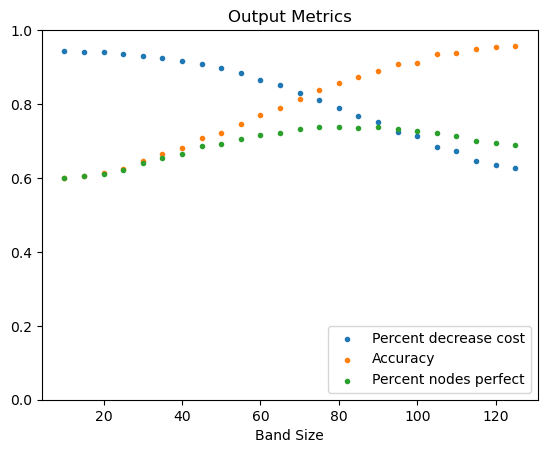

In [70]:
plot_accuracy_metrics(results_11,
    [int(x.split("=")[-1]) for x in adjacency_dirs]
)

In [ ]:
def counts_to_df(counts, file):
    

In [92]:
for a, b in sorted(zip(results_11, adjacency_dirs), key = lambda x: int(x[1].split("=")[-1])):
    print(a, b)
    break

(np.float64(0.9433098944534349), np.float64(0.5993383648159022), np.float64(0.5989320033797815), array([ 31668., 334800., 334573., 558616.])) ../../../output/adjacency_matrices/1000,11,1,1_band_size=10


In [71]:
adjacency_dir = "../../../output/adjacency_matrices"
adjacency_dirs7 = [os.path.join(adjacency_dir, x) for x in os.listdir(adjacency_dir) if ",7," in x]
results_7 = []
for ad in adjacency_dirs7:
    print(ad)
    counts7, files = parallelize_counts(ad)
    result = counts_to_results(counts7)
    results_7.append(result)

../../../output/adjacency_matrices/1000,7,1,1_band_size=60
Running Parallel Step
Total time	: 48.866931438446045
../../../output/adjacency_matrices/1000,7,1,1_band_size=35
Running Parallel Step
Total time	: 49.47434711456299
../../../output/adjacency_matrices/1000,7,1,1_band_size=125
Running Parallel Step
Total time	: 48.87935948371887
../../../output/adjacency_matrices/1000,7,1,1_band_size=15
Running Parallel Step
Total time	: 49.199570655822754
../../../output/adjacency_matrices/1000,7,1,1_band_size=95
Running Parallel Step
Total time	: 49.41996788978577
../../../output/adjacency_matrices/1000,7,1,1_band_size=85
Running Parallel Step
Total time	: 49.40993285179138
../../../output/adjacency_matrices/1000,7,1,1_band_size=25
Running Parallel Step
Total time	: 48.82303762435913
../../../output/adjacency_matrices/1000,7,1,1_band_size=20
Running Parallel Step
Total time	: 49.3979606628418
../../../output/adjacency_matrices/1000,7,1,1_band_size=40
Running Parallel Step
Total time	: 49.76291

/tmp/ipykernel_3888952/1966581602.py:85: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = matplotlib.cm.get_cmap('plasma')


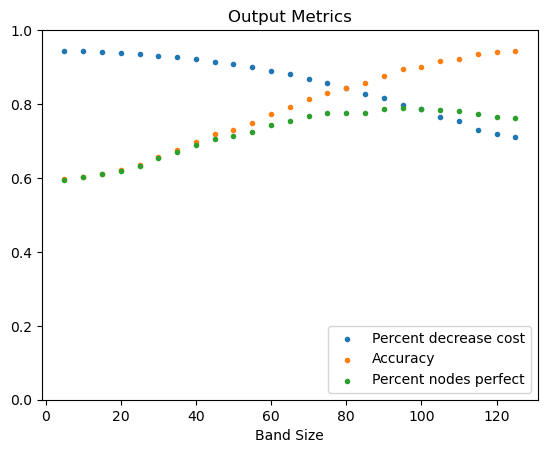

In [81]:
plot_accuracy_metrics(results_7[0:11] + results_7[12:17] + results_7[18:],
    [int(x.split("=")[-1]) for  x in adjacency_dirs7[0:11] + adjacency_dirs7[12:17] +adjacency_dirs7[18:]]
)

In [76]:
adjacency_dirs7[0:11] + adjacency_dirs7[12:17] +adjacency_dirs7[18:]

['../../../output/adjacency_matrices/1000,7,1,1_band_size=60',
 '../../../output/adjacency_matrices/1000,7,1,1_band_size=35',
 '../../../output/adjacency_matrices/1000,7,1,1_band_size=125',
 '../../../output/adjacency_matrices/1000,7,1,1_band_size=15',
 '../../../output/adjacency_matrices/1000,7,1,1_band_size=95',
 '../../../output/adjacency_matrices/1000,7,1,1_band_size=85',
 '../../../output/adjacency_matrices/1000,7,1,1_band_size=25',
 '../../../output/adjacency_matrices/1000,7,1,1_band_size=20',
 '../../../output/adjacency_matrices/1000,7,1,1_band_size=40',
 '../../../output/adjacency_matrices/1000,7,1,1_band_size=110',
 '../../../output/adjacency_matrices/1000,7,1,1_band_size=105',
 '../../../output/adjacency_matrices/1000,7,1,1_band_size=100',
 '../../../output/adjacency_matrices/1000,7,1,1_band_size=55',
 '../../../output/adjacency_matrices/1000,7,1,1_band_size=115',
 '../../../output/adjacency_matrices/1000,7,1,1_band_size=75',
 '../../../output/adjacency_matrices/1000,7,1,1_ba